In [3]:
import os
import csv
import pickle
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from collections import defaultdict

pd.set_option("display.max_rows", None)

In [4]:
data_path_text = '../data/LFM/txt'
data_path_mappings = '../data/LFM/mappings'
data_path_csv = '../data/LFM/csv'
data_path_table = '../data/LFM/table'

In [102]:
class Convert_txt_csv:
    def __init__(self):
        None
    
    def get_genres(self, filename):
        data = {}
        with open(filename, 'r', encoding = 'utf8') as f:                 
            reader = csv.reader(f, delimiter = '\t')
            for i, row in enumerate(reader):
                data[i + 1] = row[0]
            f.close()
        with open(filename.replace('txt', 'pkl'), 'wb') as f:
            pickle.dump(data, f)

    def users(self, filename):
        data = {
            'user_id': [],
            'country': [],
            'age': [],
            'gender': []
        }     
        with open(filename, 'r', encoding = 'utf8') as f:                 
            reader = csv.reader(f, delimiter = '\t')
            next(reader)
            for row in tqdm(reader):
                if(row[1] == '' or int(row[2]) < 0 or row[3] not in ['m', 'f']): continue
                data['user_id'].append(row[0])
                data['country'].append(row[1])
                data['age'].append(row[2])
                data['gender'].append(row[3])
        f.close()
        df = pd.DataFrame.from_dict(data)
        df.to_csv(filename.replace('txt', 'csv')) 
    
    def user_count(self, filename):
        df = pd.read_csv(filename, delimiter = '\t')
        df.to_csv(filename.replace('txt', 'csv'))
        
    def read_from_file(self, filename):             
        data = {
            'artist_name': [],
            'genre': []
        }
        with open(filename, 'r', encoding = 'utf8') as f:                 
            reader = csv.reader(f, delimiter = '\t')
            for row in tqdm(reader):
                row = row[:-1]
                if(len(row) > 1):
                    data['artist_name'].append(row[0])
                    data['genre'].append(row[1:])
        f.close()
        df = pd.DataFrame.from_dict(data)
        df.to_csv(filename.replace('.txt', '.csv'))

    def combine_user_data(self, mappings, users, user_count):
        with open(mappings, 'rb') as file:
            mappings = pickle.load(file)
        header_mapping = {}
        for key, val in mappings.items():
            header_mapping[key] = val['id']
            
        users_count_df = pd.read_csv(user_count, index_col = 'user_id')
        users_df = pd.read_csv(users, index_col = 'user_id')
        users_count_df = users_count_df.drop('Unnamed: 0', axis = 1)
        users_df = users_df.drop('Unnamed: 0', axis = 1)
        
        users_count_df = users_count_df.rename(columns = header_mapping)
        users_count_df = users_count_df.groupby(users_count_df.columns, axis = 1).sum()
        
        users_count_df = users_count_df.merge(users_df, on = 'user_id', how = 'inner')
        
        users_count_df.to_csv('../data/LFM/csv/user_count.csv') 
    

In [103]:
Convert_txt_csv().users(os.path.join(data_path_text, 'LFM-1b_users.txt'))
Convert_txt_csv().get_genres(os.path.join(data_path_text, 'genres_allmusic.txt'))
Convert_txt_csv().user_count(os.path.join(data_path_text, 'LFM-1b_UGP_noPC_allmusic.txt'))

Convert_txt_csv().combine_user_data(
    os.path.join(data_path_mappings, 'music_music_mapping_LFM.pkl'),
    os.path.join(data_path_csv, 'LFM-1b_users.csv'), 
    os.path.join(data_path_csv, 'LFM-1b_UGP_noPC_allmusic.csv')
)

In [135]:
def user_count_stats(user_count):
    df = pd.read_csv(user_count)
    print(df.head())
    
    print('Categories:')
    print(df.columns)
    
    print('Genders:')
    print(df['gender'].value_counts())
    
    print('Age Range')
    print(min(df['age']), max(df['age']))
    
    print('Countries:')
    df['country'].value_counts().plot(kind = 'bar')
        

   user_id  344  346  350   351  352  353  355   357  359  360   363   365  \
0      384    0   17    4   100    3   43   11    89    2   18   248   183   
1     3653    0   41   70   876   71  321  275   979   94  167  1041   886   
2     4813    0   13   25    71   23   91    9   138    8   63   128   125   
3     5069    0   91   42  1259  139  376  250  1243   86  128  1004  1263   
4     6958    0   75  162   974  165  498   99  1078   70  238   832   965   

   366  371  374 country  age gender  
0   85    7    1      UK   35      m  
1  462   99  240      UK   31      m  
2   35   14   14      US   43      m  
3  317  184   82      AT   30      m  
4  181  211   84      US   36      m  
Categories:
Index(['user_id', '344', '346', '350', '351', '352', '353', '355', '357',
       '359', '360', '363', '365', '366', '371', '374', 'country', 'age',
       'gender'],
      dtype='object')
Genders:
m    29555
f    11051
Name: gender, dtype: int64
Age Range
0 112
Countries:


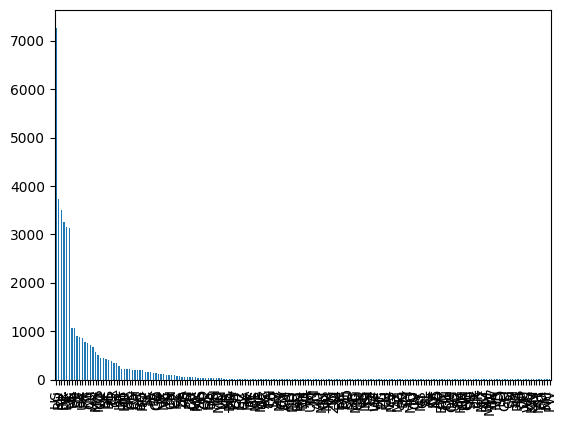

In [136]:
user_count_stats(os.path.join(data_path_csv, 'user_count.csv'))

In [39]:
categories = ['344', '346', '350', '351', '352', '353', '355', '357', '359', '360', '363', '365', '366', '371', '374']

def drop_countries(_dict, n = 1000):
    countries_to_drop = []
    for country, val in _dict.items():
        if (sum(list(val.values())) < n):
            countries_to_drop.append(country)
    for country in countries_to_drop:
        del _dict[country]
    return _dict

In [40]:
'''
data = {
        'ContentFormatId': -1,
        'CountryCode': '',
        'IsMale': True,
        'Percentage': 0
    }
'''

def fill_dict_gender(_dict):
    for country, val in _dict.items():
        if ('f' not in val.keys()):
            _dict[country]['f'] = 0
        elif ('m' not in val.keys()):
            _dict[country]['m'] = 0
    return _dict

def percentage_gender(_dict): 
    for country, val in _dict.items():
        total = sum(list(val.values()))
        _dict[country]['%f'] = round(val['f'] / total * 100, 2)
        _dict[country]['%m'] = round(val['m'] / total * 100, 2)
        _dict[country]['total'] = total
    return _dict

def create_df_gender(_dict):
    data = {
        'ContentFormatId': [],
        'CountryCode': [],
        'IsMale': [],
        'Percentage': []
    }
    for category in _dict.keys():
        for country in _dict[category].keys():
            data['ContentFormatId'].extend([category] * 2)
            data['CountryCode'].extend([country] * 2)
            data['IsMale'].append(True)
            data['Percentage'].append(_dict[category][country]['%m'])
            data['IsMale'].append(False)
            data['Percentage'].append(_dict[category][country]['%f'])
    return pd.DataFrame.from_dict(data)

def gender(filename, categories):
    row = []
    data = {}
    df = pd.read_csv(filename)
    for category in categories:
        df_category = df[[category, 'country', 'gender']]
        df_category_group = df_category.groupby(['country', 'gender'])
        country_gender_count = dict(df_category_group[category].sum())
        country_gender_dict = defaultdict(dict)
        for (country, gender), value in country_gender_count.items():
            country_gender_dict[country][gender] = value
        data[category] = percentage_gender(drop_countries(fill_dict_gender(country_gender_dict)))
    df = create_df_gender(data)
    df.to_csv(os.path.join(data_path_table, 'gender.csv'))

In [41]:
gender(os.path.join(data_path_csv, 'user_count.csv'), categories)

In [42]:
age_dict_0 = {
    (0, 24): 0,
    (25, 34): 0,
    (35, 44): 0,
    (45, 54): 0,
    (55, 64): 0,
    (65, 100): 0
}

def get_age_group(age):
    if   (age > -1 and age < 25):
        return 0, 24
    elif (age > 24 and age < 35):
        return 25, 34
    elif (age > 34 and age < 45):
        return 35, 44
    elif (age > 44 and age < 55):
        return 45, 54
    elif (age > 54 and age < 65):
        return 55, 64
    else:
        return 65, 100
    
def fill_dict_age(_dict):
    age_dict = {}
    for country in _dict.keys():
        age_dict[country] = age_dict_0.copy()
        for age in _dict[country].keys():
            min_age, max_age = get_age_group(age)
            age_dict[country][(min_age, max_age)] += _dict[country][age]
    return age_dict

def percentage_age(_dict):
    for country, val in _dict.items():
        total = sum(list(val.values()))
        for age_range in age_dict_0.keys():
            _dict[country][age_range] = round(_dict[country][age_range] / total * 100, 2)
    return _dict

def create_df_age(_dict):
    data = {
        'ContentFormatId': [],
        'CountryCode': [],
        'MinAge': [],
        'MaxAge': [],
        'Percentage': []
    }
    for category in _dict.keys():
        for country in _dict[category].keys():
            for age in _dict[category][country].keys():
                data['ContentFormatId'].append(category)
                data['CountryCode'].append(country)
                data['MinAge'].append(age[0])
                data['MaxAge'].append(age[1])
                data['Percentage'].append(_dict[category][country][age])
    return pd.DataFrame.from_dict(data)

def age(filename, categories):
    row = []
    data = {}
    df = pd.read_csv(filename)
    for category in categories:
        df_category = df[[category, 'country', 'age']]
        df_category_group = df_category.groupby(['country', 'age'])
        country_age_count = dict(df_category_group[category].sum())
        country_age_dict = defaultdict(dict)
        for (country, age), value in country_age_count.items():
            country_age_dict[country][age] = value
        data[category] = percentage_age(fill_dict_age(drop_countries(country_age_dict)))
    df = create_df_age(data)
    df.to_csv(os.path.join(data_path_table, 'age.csv'))

In [43]:
age(os.path.join(data_path_csv, 'user_count.csv'), categories)